<a href="https://colab.research.google.com/github/mpHarm88/ds8_unit2_proj/blob/master/ds8_unit2_proj_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot, PDPIsolate
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import plotly.express as px
import shap

#Load and Clean Data

In [4]:
season = 'https://raw.githubusercontent.com/mpHarm88/ds8_unit2_proj/master/nba-players-stats(1)/Seasons_Stats.csv'
player = 'https://raw.githubusercontent.com/mpHarm88/ds8_unit2_proj/master/nba-players-stats(1)/Players.csv'

df = pd.read_csv(season)
df2 = pd.read_csv(player)
df_season = df
df_player = df2
print(df_season.shape, df_player.shape)

(24691, 53) (3922, 8)


In [0]:
#changing to pd date time format
df_player['born_year'] = pd.to_datetime(df_player['born'], format='%Y')
df_player['birth_year'] = df_player['born_year'].dt.year

In [6]:
#MERGE SEASON AND PALYERS TO GET HEIGHT AND WEIGHT
df_merge = pd.merge(df_season,df_player, on='Player')
print(df_merge.shape)

(24691, 62)


In [0]:
#MAKING DICT TO MAP OVER NEW COLUMN
dict_games = {
    1950:68,
    1951:66,
    1952:70,
    1953:72,
    1954:72,
    1955:72,
    1956:72,
    1957:72,
    1958:72,
    1959:75,
    1960:79,
    1961:80,
    1962:80,
    1963:80,
    1964:80,
    1965:80,
    1966:81,
    1967:82,
    1968:82,
    1969:82,
    1970:82,
    1971:82,
    1972:82,
    1973:82,
    1974:82,
    1975:82,
    1976:82,
    1977:82,
    1978:82,
    1979:82,
    1980:82,
    1981:82,
    1982:82,
    1983:82,
    1984:82,
    1985:82,
    1986:82,
    1987:82,
    1988:82,
    1989:82,
    1990:82,
    1991:82,
    1992:82,
    1993:82,
    1994:82,
    1995:82,
    1996:82,
    1997:82,
    1998:82,
    1999:50, #NBA Lockout
    2000:82,
    2001:82,
    2002:82,
    2003:82,
    2004:82,
    2005:82,
    2006:82,
    2007:82,
    2008:82,
    2009:82,
    2010:82,
    2011:66, #NBA Lockout
    2012:82,
    2013:82,
    2014:82,
    2015:82,
    2016:82,
    2017:82,
    2018:82,
}

#Split the Data

In [8]:
#Using dict_games to map over a new series and normalize my y('G')
df_merge['season_length'] = df_merge['Year'].map(dict_games)
df_merge['season_pct_played'] = df_merge['G']/df_merge['season_length']

#Making train and test df
testing_merge = df_merge[df_merge['Year']>= 2005]
training_merge = df_merge[df_merge['Year'] < 2005]
testing_merge.shape, training_merge.shape

((7603, 64), (17021, 64))

In [31]:
target = 'season_pct_played'
features = ['Pos', 'BLK', 'STL', 'AST','Age', 'TRB', 'PTS']

#DF MERGE X and y
train_merge, val_merge = train_test_split(training_merge, random_state=42) #Splitting merged df

X_train_merge = train_merge[features]
y_train_merge = train_merge[target]

X_val_merge = val_merge[features]
y_val_merge = val_merge[target]

X_test_merge = testing_merge[features]
y_test_merge = testing_merge[target]

X_test_cv_merge = training_merge[features]
y_train_cv_merge = testing_merge[target]

print(f'X_train: {X_train_merge.shape}')
print(f'X_val: {X_val_merge.shape}')
print(f'X_test: {X_test_merge.shape}')

X_train: (12765, 7)
X_val: (4256, 7)
X_test: (7603, 7)


#Model

In [32]:
gb_merge = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'), 
    XGBRegressor(
        n_estimators=1000, 
        n_jobs=-1,
        max_depth=10,
        learning_rate=0.2,
        gamma=0.2
    )
)

gb_merge.fit(X_train_merge, y_train_merge)
y_pred_merge = gb_merge.predict(X_val_merge)
print('Gradient Boosting R^2', r2_score(y_val_merge, y_pred_merge))

[17:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Gradient Boosting R^2 0.8469380700322386


In [11]:
#TEST SCORES
y_pred_merge_test = gb_merge.predict(X_test_merge)
print('Gradient Boosting R^2', r2_score(y_test_merge, y_pred_merge_test))
print('Gradient Boosting RMSE', np.sqrt(mean_squared_error(y_test_merge, y_pred_merge_test)))

Gradient Boosting R^2 0.8099054247226722
Gradient Boosting RMSE 0.14216771318616875


#PDP Plot/Interaction Visuals

(4256, 7)
(4256, 7)
(4256, 7)


(-0.22, 1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


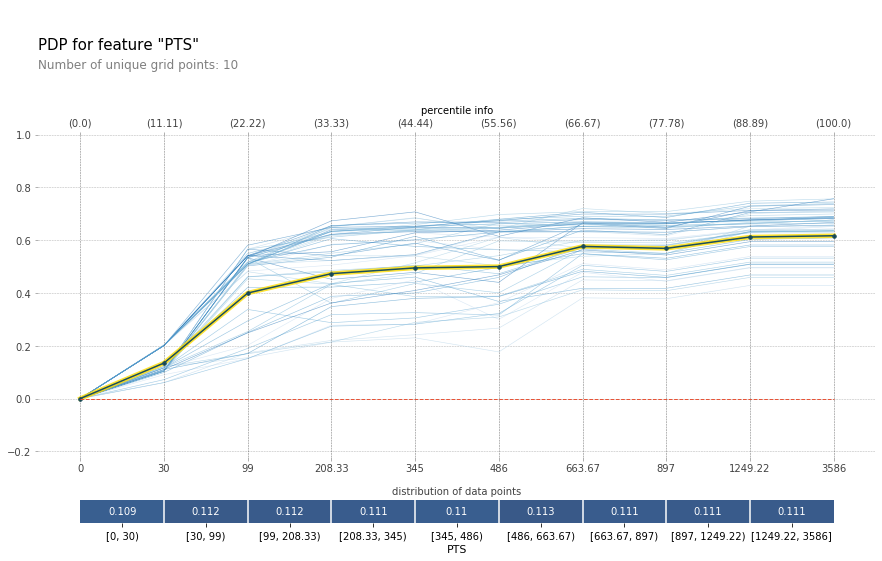

In [12]:
#PDP
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train_merge)
X_val_encoded = encoder.transform(X_val_merge)

imputer = make_pipeline( #Making imputer so I dont have to drop many NaN values
    ce.OrdinalEncoder(),
    SimpleImputer()

)

X_train_imputed = imputer.fit_transform(X_train_merge)
X_val_imputed = imputer.transform(X_val_merge)


X_val_encoded_pdp =X_val_encoded.dropna()
X_val_merge_pdp = X_val_merge.fillna(0) 

print(X_val_merge_pdp.shape)
print(X_val_merge.shape)
print(X_val_imputed.shape)

feature = 'PTS'

isolated = pdp_isolate(
    model = gb_merge,
    dataset = X_val_merge_pdp, #Must use dataset that doesnt have NaN value present
    model_features = list(X_val_merge.columns),
    feature = feature
)

grid = isolated.feature_grids
pdp = isolated.pdp

pdp_plot(isolated,
         feature_name=feature , 
         plot_lines=True, 
         frac_to_plot=50,
         plot_pts_dist=True,
         x_quantile=True,
        show_percentile=True)
plt.ylim(-0.22,1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


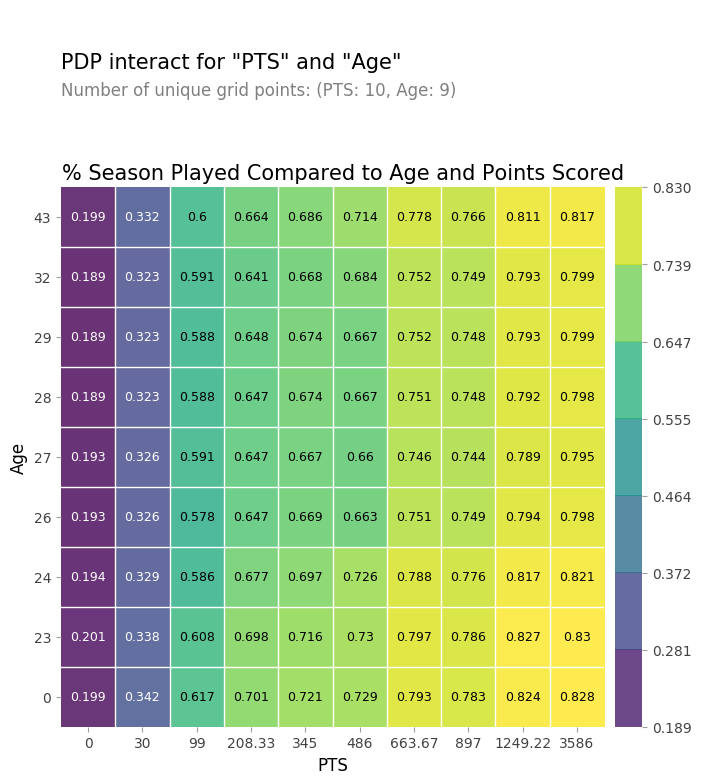

In [13]:
plt.rcParams["figure.dpi"]=100
features = ['PTS', 'Age']

interaction = pdp_interact(
    model=gb_merge,
    dataset=X_val_merge_pdp,
    model_features=X_val_merge.columns,
    features=features,
)


fig, axes = pdp_interact_plot(interaction, feature_names=features, plot_type='grid')
plt.title('% Season Played Compared to Age and Points Scored', position=(-10,1), fontsize=15);

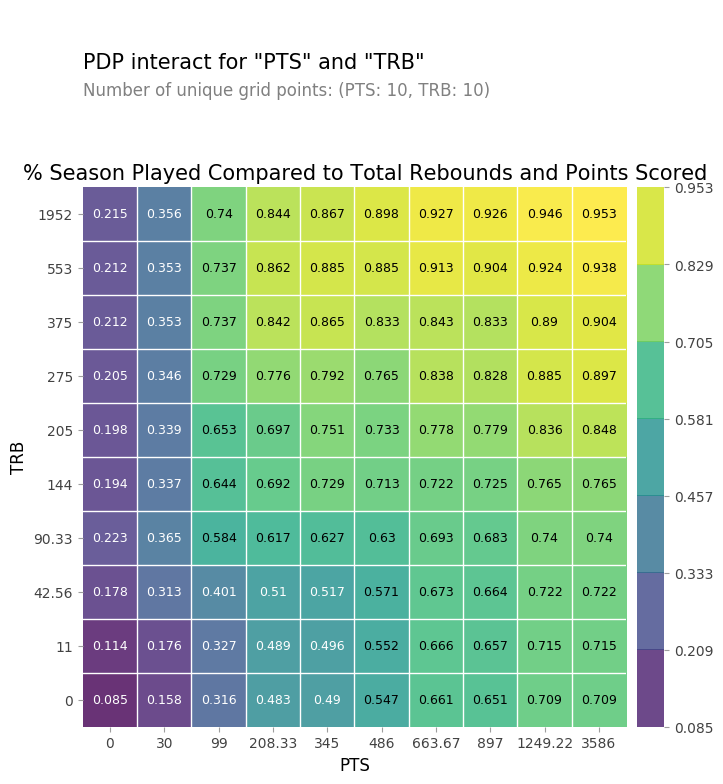

In [14]:
plt.rcParams["figure.dpi"]=100
features = ['PTS', 'TRB']

interaction = pdp_interact(
    model=gb_merge,
    dataset=X_val_merge_pdp,
    model_features=X_val_merge.columns,
    features=features,
)


fig, axes = pdp_interact_plot(interaction, feature_names=features, plot_type='grid')
plt.title('% Season Played Compared to Total Rebounds and Points Scored', position=(-10,1), fontsize=15);

#Permutation/Feature Importance

In [15]:
import eli5
from eli5.sklearn import PermutationImportance
# DF_MERGE PERMUTATION IMPORTANCES

processor_merge = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median')
)

X_train_permute_merge = X_train_merge.drop(columns=['Pos', 
                                                   ])

X_val_permute_merge = X_val_merge.drop(columns=['Pos', 
                                               ])

feature_names_merge = X_val_permute_merge.keys()

X_train_processed_merge = processor_merge.fit_transform(X_train_permute_merge)
X_val_processed_merge = processor_merge.transform(X_val_permute_merge)

permuteXGB_merge = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(n_estimators=200, n_jobs=-1)
)

permuteXGB_merge.fit(X_train_permute_merge, y_train_merge)
y_pred_merge = permuteXGB_merge.predict(X_val_permute_merge)
print('Gradient Boosting R^2', r2_score(y_val_merge, y_pred_merge))

permuter_merge = PermutationImportance(
    permuteXGB_merge, 
    scoring='r2',
    n_iter=2,
    random_state=42
)

permuter_merge.fit(X_val_processed_merge, y_val_merge)
feature_names_merge = X_val_permute_merge.columns.tolist()


eli5.show_weights(
    permuteXGB_merge,
    top=None,
    feature_names = X_val_permute_merge.keys()
)

Using TensorFlow backend.


[17:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Gradient Boosting R^2 0.8515346819566902


X_train_merge shape after encoding (12765, 7)


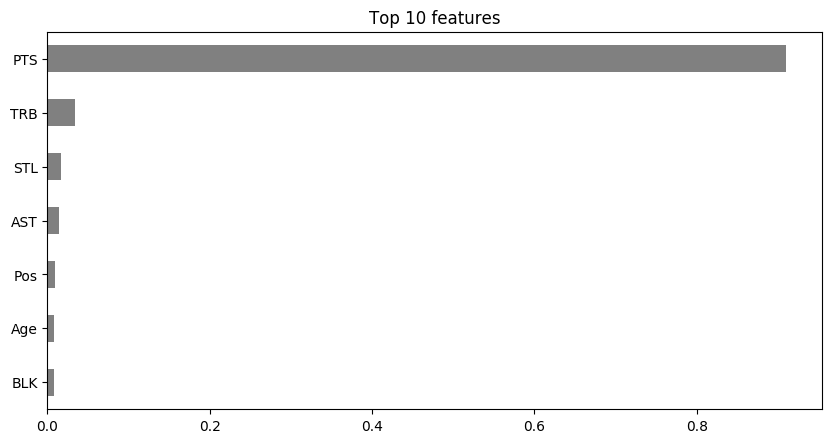

In [16]:
# DF_MERGE IMPORTANCES

encoder_merge = gb_merge.named_steps['ordinalencoder']
encoded_merge = encoder_merge.transform(X_train_merge)
print('X_train_merge shape after encoding', encoded_merge.shape)

model_merge = gb_merge.named_steps['xgbregressor']
importances_merge = pd.Series(model_merge.feature_importances_, index = encoded_merge.columns)

n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances_merge.sort_values()[-n:].plot.barh(color='grey');

#Shapley Visuals

In [0]:
#Shapley
processor_class = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'median')
)

X_train_processed_merge_shap = processor_class.fit_transform(X_train_merge)
X_val_processed_merge_shap = processor_class.transform(X_val_merge)

eval_set=[(X_train_processed_merge_shap, y_train_merge),
        (X_val_processed_merge_shap, y_val_merge)]

model_shap = XGBRegressor(n_estimators = 1000,
                     n_jobs=-1,
                     max_depth=5,
                     )


model_shap.fit(X_train_processed_merge_shap, 
               y_train_merge, 
               eval_set = eval_set, 
               eval_metric = 'rmse',
               early_stopping_rounds=50)


In [18]:
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_train_processed_merge_shap)
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values=shap_values,
    features = X_train_merge.columns)

In [19]:
#Hilton Armstrong Example in Insights page
row = X_test_merge.iloc[[4000]]
row

Pos   BLK   STL   AST   Age    TRB    PTS
21088   C  34.0  15.0  23.0  23.0  163.0  178.0

In [21]:
actual = df_merge[['Player', 'G', 'season_length', 'season_pct_played']].iloc[[21088]]
actual

Player     G  season_length  season_pct_played
21088  Hilton Armstrong  65.0           82.0           0.792683

In [22]:
import shap
explainer = shap.TreeExplainer(model_shap)
row_processed = processor_class.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

#Validation Curve Visual

In [23]:
#Validation Curve

encoder = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'))  


X_train_encoded = encoder.fit_transform(X_train_merge)
X_val_encoded = encoder.transform(X_val_merge)

eval_set = [(X_train_encoded, y_train_merge), 
            (X_val_encoded, y_val_merge)]

model = XGBRegressor(
    n_estimators=1000, 
    max_depth=10,       
    learning_rate=0.2, 
    n_jobs=-1,
    gamma=0.2
)

model.fit(X_train_encoded, y_train_merge, eval_set=eval_set, 
          eval_metric='rmse', early_stopping_rounds=50)

[17:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.298996	validation_1-rmse:0.302721
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.25002	validation_1-rmse:0.254691
[2]	validation_0-rmse:0.212604	validation_1-rmse:0.218137
[3]	validation_0-rmse:0.184412	validation_1-rmse:0.191007
[4]	validation_0-rmse:0.163541	validation_1-rmse:0.171198
[5]	validation_0-rmse:0.148526	validation_1-rmse:0.157152
[6]	validation_0-rmse:0.137894	validation_1-rmse:0.147452
[7]	validation_0-rmse:0.130276	validation_1-rmse:0.140957
[8]	validation_0-rmse:0.124951	validation_1-rmse:0.136751
[9]	validation_0-rmse:0.121577	validation_1-rmse:0.133864
[10]	validation_0-rmse:0.118874	validation_1-rmse:0.131951
[11]	validation_0-rmse:0.117054	validation_1-rmse:0.130579
[12]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

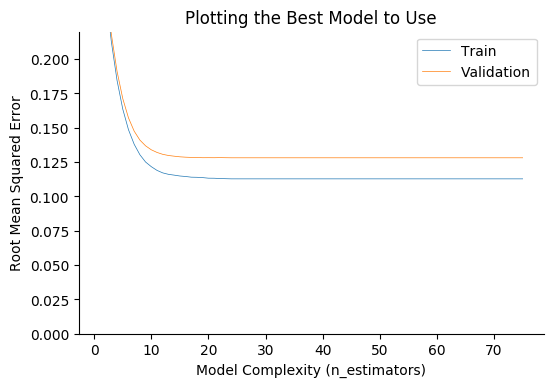

In [24]:
plt.rcParams["figure.dpi"]=100
results = model.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']
epoch = range(1, len(train_error)+1)


fig, ax = plt.subplots()
plt.plot(epoch, train_error, label='Train', linewidth=0.5)
plt.plot(epoch, val_error, label='Validation', linewidth=0.5)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title("Plotting the Best Model to Use")
plt.ylim((0, .22))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend();

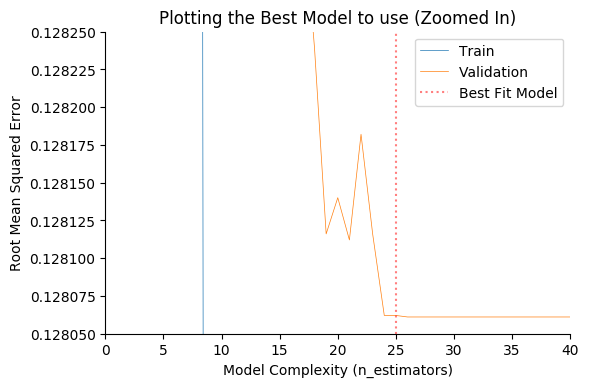

In [25]:
fig, ax = plt.subplots()
plt.plot(epoch, train_error, label='Train', linewidth=0.5)
plt.plot(epoch, val_error, label='Validation', linewidth=0.5)
plt.axvline(25, color='r', ls=':', alpha=.5, label="Best Fit Model")
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Plotting the Best Model to use (Zoomed In)')
# plt.ylim((0.112, .131))
plt.ylim((.12805, .12825))
plt.xlim((0,40))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend();

#Plotly Interactive Graph Visual

In [29]:
season_plotly = df_season[['Year','PTS', 'Player', 'G', 'Age', 'PF']]
season_plotly = df_season.rename(columns={'PTS':'Total Points', 'G':'Games Played', 'PF':'Personal Fouls'})
fig = px.scatter(season_plotly, x='Year', y='Total Points', hover_data=["Player",'Age','Games Played', 'Personal Fouls'], )
fig.show()